<a href="https://colab.research.google.com/github/nirnayroy/2d-billiards/blob/master/Copy_of_2d_billiards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fermi Acceleration in 2d-billiards

# Imports

In [ ]:
!pip install shapely

In [1]:
#@title
import numpy as np
#from scipy import optimize
#from scipy.misc import derivative
import matplotlib.pyplot as plt
import pickle 
from sklearn.preprocessing import normalize

#from shapely.geometry import LineString
#from shapely.geometry import Point

# Some functions

In [79]:
#slit position
def slit(t, s, omega):
    return -s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


# Travel for rectangle with slit

In [ ]:

#mapping function from one state to the next  
def travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            #print('next wall: top')
        else:
            yf = -h
            #print('next wall: bottom')
    
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
   
    return (xf, yf, uf, vf, tf)


In [ ]:

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


In [ ]:

def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


In [ ]:

omega=(2*np.pi/70)
lam = 1
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
    dbfile = open('ensemble2_100', 'ab') 
      
    # source, destination 
    pickle.dump(systems, dbfile)                      
    dbfile.close()
    return systems



In [ ]:

systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)


In [ ]:
import matplotlib.pyplot as plt
def load_and_plot(time_step=1):
    
    dbfile = open('ensemble2', 'rb')      
    systems = pickle.load(dbfile) 
    
    t = 1
    
    tfs = []
    for i in systems:
        last_state = i[len(i)-1]
        #print(last_state)
        (x, y, u, v, tm) = last_state
        tfs.append(tm)
    
    tf = min(tfs)
     
    #print(tf)
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<t2 and t>t1:
                    v += ((v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        #print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

[4333.7531107363575, 4620.855276032316, 5166.599944930533, 5699.88178690181, 6123.237379250558, 6342.2125597567365, 6350.904854983463, 6856.617443316063, 7486.465641915043, 8012.077270917688, 8486.73231278515, 8652.635143721285, 9491.019845687464, 9577.259902409387, 10287.677709275411, 10466.46170717086, 11347.304446746577, 12545.698230169282, 14024.503667592347, 14909.898383584286, 17242.622126118804, 18677.013810298922, 20508.175033088428, 23931.24883240195, 21108.74190138676, 21780.135594746956, 23576.32517277359, 23678.46022377276, 26002.784754953438, 27028.108758986356, 30821.53984096212, 30936.95811236209, 29092.146627217953, 31125.56130226421, 30880.65087704504, 31982.442207685974]
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501]


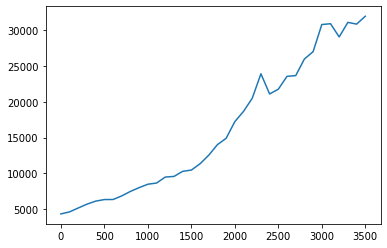

In [ ]:
load_and_plot(time_step=100)

# Stadium Billiards

In [5]:
#slit position
def slit(t, s, omega):
    return -h-s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y

def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))


def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    m = (vel_vec[1]/vel_vec[0])
    k = 0
    #print('entered enclosure:', 'x:', x, 'y:', y, 'u:', u, 'v:', v)
    while True:
        
        a = 1+ (m**2)
        b = -2*((m**2)*x - (m*(y-h)))
        c = ((m*x)**2) - (r**2) + ((y-h)**2) - (2*m*x*(y-h))
        disc = (b**2) - (4*a*c) 
        #y = sem_func(x, r)
        #print('x:', x, 'y:', y)
        #print('disc:', (b**2) - (4*a*c) )

        if disc > 0:
            sol1 = (-b-np.sqrt(disc))/(2*a) 
            sol2 = (-b+np.sqrt(disc))/(2*a)
            ysol1 = m*(sol1-x) + y
            ysol2 = m*(sol2-x) + y
            #print('sol1:', sol1, 'sol2:', sol2)
            #print('ysol1:', ysol1, 'ysol2:' ,ysol2)
            if (ysol1>h) != (ysol2>h):
                if k ==0:
                    #print('first collision')
                    if (ysol1>h):
                        xf = sol1
                        yf = ysol1
                    else:
                        xf = sol2
                        yf = ysol2
                else:
                    #print('last collision')
                    yf = h
                    xf = x + ((h-y)/m)
                    ty = (yf-y)/vel_vec[1]
                    tx = (xf-x)/vel_vec[0]
                    if tx - ty > 0.000001:
                        print('failed!: tx', tx, 'ty', ty)
                    t+=ty
                    #print('exit enclosure:', 'x:', xf, 'y:', yf, 'u:', vel_vec[0], 'v:', vel_vec[1])
                    return (xf, yf, vel_vec[0], vel_vec[1], t)
            elif ((ysol1>h) and (ysol2>h)) and k>0:
                if (x - sol1) < 0.000001:
                    xf = sol2
                    yf = ysol2
                else:
                    xf = sol1
                    yf = ysol1
                    
            else:
                print('2 y neg:' ,'ys:', ysol1, ysol2, 'xs', sol1, sol2)
        else:
            
            print('disc_neg')
        
        p = float(d_sem_func(xf, r))
        #print('p:', p)
        if p != 0:
            nor_vec = np.array([-np.sign(p), -np.sign(p)*(1/p)])
            #print('nor vec:', nor_vec)
            nor_vec = normalize(nor_vec.reshape(2, 1))
        else:
            nor_vec = np.array([0, -1]).reshape(2, 1)
        #nor_inc = normalize(vel_vec)
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        #print('ref:', ref, 'ref shape:', ref.shape)
        if np.linalg.norm(vel_vec) - np.linalg.norm(ref)>1e-5:
            print('unnormalized collision:', np.linalg.norm(vel_vec), np.linalg.norm(ref))
        tx = (xf-x)/vel_vec[0]
        ty = (yf-y)/vel_vec[1]
        if tx - ty > 0.0000001:
            print('failed!: tx', tx, 'ty', ty)
        t+=tx
        x = xf
        y = yf
        vel_vec = np.array(ref)
        k += 1
        m = ref[1]/ref[0]
        #print('x:', x, 'y:', y, 'vel_vec:', vel_vec, 'm:', m)
        


#mapping function from one state to the next  
def stadium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 
    #       't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 1e8
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        sign = np.sign(yf)
        if abs(yf)>h:
            y_left = abs(yf - (sign*h))
            quo = y_left//(2*h)
            rem = y_left%(2*h)
            if quo%2 == 1:
                yf = sign*(rem-h)
            elif quo%2 == 0:
                yf = sign*(h-rem)
                vf = -v
        if abs(yf)>h:
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            #print('next wall: semi-circle enclosure')
            (xf, yf , uf, vf, tf) = semicircle_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            #print('bottom bar')
            tf1 = tf - (2*s/v)
            tf2 = tf + (2*s/v)
            xf1 = x + u*time_step[di]
            if (coll(tf1, y, v, t, s, omega)*coll(tf2, y, v, t, s, omega))<0:
                root = rtsafe(i, tf+(np.pi/omega),y, v, t, s, omega, xacc=0.0000001, maxit = 100)
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v
                y_coll = slit(root ,s , omega)
                tf2 = root + ((-h-y_coll)/vf)
                xf = xf1 + u*(tf2-root)
                uf = u
                sign = np.sign(xf)
                if abs(xf)>l:
                    x_left = abs(xf - (sign*l))
                    quo = x_left//(2*l)
                    rem = x_left%(2*l)
                    if quo%2 == 1:
                        xf = sign*(rem-l)
                    elif quo%2 == 0:
                        xf = sign*(l-rem)
                        uf = -u
                yf = -h
                
                
            else:
                print('root out of bounds')
            
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = stadium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states

'''
def plot_bill(states):
    #xs = []
    #ys = []
    es = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        es.append((v**2)+(u**2))
        #xs.append(x)
        #ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, es)
    plt.show()


res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)
'''

    


    


'\ndef plot_bill(states):\n    #xs = []\n    #ys = []\n    es = []\n    ts = []\n    for i in states:\n        (x, y, u, v, t) = i\n        es.append((v**2)+(u**2))\n        #xs.append(x)\n        #ys.append(y)\n        ts.append(t)\n    #plt.scatter(xs, ys)\n    #plt.xlim(-20, 20)\n    #plt.ylim(-10, 10)\n    #plt.show()\n    plt.plot(ts, es)\n    plt.show()\n\n\nres = iteration(xi =-0.70, yi=-0.65, ui = ui, \n                vi =vi,\n                omega=omega, lam=1, l=2, h=1,s = 0.1, \n                ni=10000)\nplot_bill(res)\n'

In [ ]:
import matplotlib.pyplot as plt


omega=(2*np.pi/70)
lam = 1
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
        print(k)

      
    # source, destination 
    np.save('stadium_100.npy', systems)                      
    return systems
omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1



systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)
print('saved!!')

1
2
3
4
5
6
7
8
9
10


In [196]:
def load_and_plot(time_step=1):
    
    dbfile = open('stadium_100'', 'rb')      
    systems = pickle.load(dbfile) 
    
    t = 1
    
    tfs = []
    for i in systems:
        last_state = i[len(i)-1]
        #print(last_state)
        (x, y, u, v, tm) = last_state
        tfs.append(tm)
    
    tf = min(tfs)
     
    #print(tf)
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<t2 and t>t1:
                    v += ((v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        #print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

load_and_plot(time_step=100)

KeyboardInterrupt: 

## Trapezium Billiards

In [156]:
def trapezium_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    if v<0:
        print('moving the other direction')
    st = 'en'
    vel_vec = np.array([u, v])
    
    if u == 0:
        m = np.inf
    else:
        m = v/u
    slope = 1
    wall_y_left = h
    wall_y_right = slope*(2*l)+h
    while True:
        ball_y_right = m*(l-x)+y 
        ball_y_left = m*(-l-x)+y 
        if m == slope:
            x_int = 3
        else:
            x_int = (h-y+(slope*l)+(m*x))/(m-slope)
        print(x_int)
        if ((-l<x_int) and (x_int<l)) and st != "sl" :
            print('slop')
            xf = x_int
            yf = m*(xf-x)+y
            nor_vec = normalize(np.array([1, -(1/slope)]).reshape(2,1))
            st = "sl"
        elif h < ball_y_right < wall_y_right and st != "ve":
            #hit vertical
            print('vert')
            xf = l
            yf = ball_y_right
            nor_vec = normalize(np.array([-1, 0]).reshape(2,1))
            st = "ve"

        else:
            print('exit')
            yf = h
            xf = x + ((h-y)/vel_vec[1])* vel_vec[0]
            t += (h-y)/vel_vec[1]
            if vel_vec[1]>0:
                print('other way:', (h-y)/vel_vec[1])
            return (xf, yf, vel_vec[0], vel_vec[1], t)
                
        t += (xf-x)/vel_vec[0]
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        if np.linalg.norm(vel_vec) != np.linalg.norm(ref):
            print('unnormalized collision')
        x = xf
        y = yf
        vel_vec = np.array(ref)
        print(ref)
        m = float(ref[1]/ref[0])
        
omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
#entered enclosure: x: [-1.30463345] y: 1 u: [-0.70840413] v: [0.70580705]
trapezium_enclosure(x=0, y=h , u=1, v=1, t=0, lam=1, l=l, h=h, s=s, omega=omega)  
                              

3
vert
[[-1.]
 [ 1.]]
1.0
slop
[[ 1.]
 [-1.]]
1.0
vert
[[-1.]
 [-1.]]
3
exit


(array([0.]), 1, array([-1.]), array([-1.]), array([6.]))

next wall: trapezium enclosure
-0.62625
slop
[[ 5.93328772]
 [-2.85676816]]
-0.6262500000000016
vert
[[-5.93328772]
 [-2.85676816]]
-5.503571428571432
exit
next wall: left
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.93848277]
slop
[[ 4.0869114 ]
 [-5.16503165]]
[-0.93848277]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.40290291]
slop
[[ 4.83831686]
 [-4.47499698]]
[-0.40290291]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.87638598]
slop
[[ 4.60410298]
 [-4.72277574]]
[-1.87638598]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.08652147]
slop
unnormalized collision
[[ 4.68950867]
 [-4.64699672]]
[-0.08652147]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97780122]
slop
[[ 4.66857927]
 [-4.67905575]]
[-1.97780122]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04704795]
slop
unnormalized collision
[[ 4.6836723 ]
 [-4.67613185]]
[-0.04704795]
exit
next wall: rig

unnormalized collision
[[ 4.72759787]
 [-4.72319444]]
[-0.02460991]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97667626]
slop
[[ 4.73662156]
 [-4.73211186]]
[-1.97667626]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01716054]
slop
unnormalized collision
[[ 4.74558191]
 [-4.74110385]]
[-0.01716054]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97296766]
slop
unnormalized collision
[[ 4.75437441]
 [-4.74998019]]
[-1.97296766]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00987902]
slop
[[ 4.76302445]
 [-4.75870139]]
[-0.00987902]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96960991]
slop
unnormalized collision
[[ 4.77113669]
 [-4.76708229]]
[-1.96960991]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00313379]
slop
unnormalized collision
[[ 4.77903501]
 [-4.77508748]]
[-0.00313379]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9667

next wall: right
next wall: trapezium enclosure
[-0.02668437]
slop
unnormalized collision
[[ 4.72432389]
 [-4.71997457]]
[-0.02668437]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97739067]
slop
[[ 4.73333314]
 [-4.72883065]]
[-1.97739067]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01925455]
slop
unnormalized collision
[[ 4.7422995 ]
 [-4.73781843]]
[-0.01925455]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97362327]
slop
[[ 4.75119245]
 [-4.74674805]]
[-1.97362327]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01189828]
slop
unnormalized collision
[[ 4.75996209]
 [-4.75557928]]
[-0.01189828]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9701622]
slop
[[ 4.76828416]
 [-4.76412494]]
[-1.9701622]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00498848]
slop
[[ 4.77640921]
 [-4.77234841]]
[-0.00498848]
exit
next wall: right
bottom bar
next wall: trapezium

slop
[[ 4.78106319]
 [-4.77725076]]
[-1.96766569]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00062982]
slop
[[ 4.78844616]
 [-4.78475609]]
[-0.00062982]
vert
[[-4.78844616]
 [-4.78475609]]
[-5188.26802761]
exit
bottom bar
next wall: trapezium enclosure
[-1.96512828]
slop
unnormalized collision
[[ 4.7948007 ]
 [-4.79162448]]
[-1.96512828]
exit
bottom bar
next wall: trapezium enclosure
[2111.05674594]
vert
[[-4.7948007 ]
 [ 4.80388165]]
[0.0047013]
slop
[[ 4.80085658]
 [-4.79782959]]
[0.0047013]
vert
[[-4.80085658]
 [-4.79782959]]
[-6325.17023783]
exit
bottom bar
next wall: trapezium enclosure
[-1.96330297]
slop
unnormalized collision
[[ 4.80561694]
 [-4.80323734]]
[-1.96330297]
exit
bottom bar
next wall: trapezium enclosure
[2889.22146595]
vert
[[-4.80561694]
 [ 4.81225018]]
[0.00874355]
slop
unnormalized collision
[[ 4.81004011]
 [-4.80782903]]
[0.00874355]
vert
[[-4.81004011]
 [-4.80782903]]
[-8659.66439785]
exit
bottom bar
next wall: trapezium enclosure
[-1.9

[[-4.81432179]
 [ 4.81005091]]
[0.0096968]
slop
[[ 4.81147495]
 [-4.81289858]]
[0.0096968]
vert
[[-4.81147495]
 [-4.81289858]]
[13457.36344995]
exit
bottom bar
next wall: trapezium enclosure
[-1.96570095]
slop
unnormalized collision
[[ 4.80708039]
 [-4.80927817]]
[-1.96570095]
exit
bottom bar
next wall: trapezium enclosure
[-2728.05498396]
vert
[[-4.80708039]
 [ 4.80006419]]
[0.0062123]
slop
unnormalized collision
[[ 4.80240406]
 [-4.8047428 ]]
[0.0062123]
vert
[[-4.80240406]
 [-4.8047428 ]]
[8192.16495188]
exit
bottom bar
next wall: trapezium enclosure
[-1.96848938]
slop
[[ 4.79635729]
 [-4.79938163]]
[-1.96848938]
exit
bottom bar
next wall: trapezium enclosure
[-2033.832347]
vert
[[-4.79635729]
 [ 4.78694895]]
[0.00133656]
slop
unnormalized collision
[[ 4.79008711]
 [-4.79322323]]
[0.00133656]
vert
[[-4.79008711]
 [-4.79322323]]
[6109.497041]
exit
bottom bar
next wall: trapezium enclosure
[-1.97182887]
slop
unnormalized collision
[[ 4.78269396]
 [-4.78639197]]
[-1.97182887]
exit
bott

next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97600732]
slop
[[ 4.73993949]
 [-4.73543055]]
[-1.97600732]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01870352]
slop
unnormalized collision
[[ 4.7489048 ]
 [-4.74442426]]
[-0.01870352]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97228084]
slop
unnormalized collision
[[ 4.75773173]
 [-4.7533203 ]]
[-1.97228084]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01140436]
slop
[[ 4.76642225]
 [-4.76207897]]
[-0.01140436]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96889063]
slop
[[ 4.77460382]
 [-4.77051478]]
[-1.96889063]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00461246]
slop
unnormalized collision
[[ 4.78257679]
 [-4.77859196]]
[-0.00461246]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96600327]
slop
unnormalized collision
[[ 4.78969784]
 [-4.78613863]]
[-1.96600327]
exit
bottom bar
n

bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04642337]
slop
[[ 4.67859068]
 [-4.68167965]]
[-0.04642337]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99463884]
slop
[[ 4.67370982]
 [-4.67615088]]
[-1.99463884]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.050627]
slop
[[ 4.66916849]
 [-4.67143971]]
[-0.050627]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99568734]
slop
unnormalized collision
[[ 4.66613698]
 [-4.66765298]]
[-1.99568734]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05330099]
slop
[[ 4.66346884]
 [-4.6648031 ]]
[-0.05330099]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99583815]
slop
unnormalized collision
[[ 4.66244599]
 [-4.66295744]]
[-1.99583815]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05430475]
slop
[[ 4.66179124]
 [-4.66211862]]
[-0.05430475]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1

 [-4.76989159]]
[-0.01033505]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97783833]
slop
[[ 4.75695604]
 [-4.76136275]]
[-1.97783833]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0176088]
slop
[[ 4.74813208]
 [-4.75254612]]
[-0.0176088]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98176141]
slop
[[ 4.73911768]
 [-4.74362703]]
[-1.98176141]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02510165]
slop
[[ 4.73017144]
 [-4.73464668]]
[-0.02510165]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98551838]
slop
unnormalized collision
[[ 4.7214168 ]
 [-4.72579615]]
[-1.98551838]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0324254]
slop
unnormalized collision
[[ 4.71281004]
 [-4.71711539]]
[-0.0324254]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98890869]
slop
[[ 4.70476906]
 [-4.70879127]]
[-1.98890869]
exit
bottom bar
next wall: right

unnormalized collision
[[ 4.70310034]
 [-4.707165  ]]
[-0.03729995]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99064641]
slop
[[ 4.69577711]
 [-4.69944015]]
[-1.99064641]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04349516]
slop
[[ 4.6887168 ]
 [-4.69224828]]
[-0.04349516]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99303072]
slop
unnormalized collision
[[ 4.68277618]
 [-4.68574743]]
[-1.99303072]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04856622]
slop
unnormalized collision
[[ 4.67715032]
 [-4.6799641 ]]
[-0.04856622]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99463164]
slop
unnormalized collision
[[ 4.67290358]
 [-4.67502744]]
[-1.99463164]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05224396]
slop
unnormalized collision
[[ 4.66900709]
 [-4.67095574]]
[-0.05224396]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9953

unnormalized collision
[[ 4.66632701]
 [-4.66579538]]
[-1.99435409]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0542892]
slop
unnormalized collision
[[ 4.66774374]
 [-4.66703543]]
[-0.0542892]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99273868]
slop
[[ 4.67081124]
 [-4.66927774]]
[-1.99273868]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05187856]
slop
[[ 4.67419877]
 [-4.67250531]]
[-0.05187856]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99035883]
slop
unnormalized collision
[[ 4.67910905]
 [-4.67665456]]
[-1.99035883]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04792656]
slop
[[ 4.68428931]
 [-4.6816999 ]]
[-0.04792656]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98734395]
slop
unnormalized collision
[[ 4.69078518]
 [-4.68753837]]
[-1.98734395]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04264619]
slop
[[ 4.69748704]

[-0.0247843]
slop
[[ 4.74299845]
 [-4.73855216]]
[-0.0247843]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97349263]
slop
[[ 4.75200528]
 [-4.747504  ]]
[-1.97349263]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01736304]
slop
[[ 4.7609274 ]
 [-4.75646843]]
[-0.01736304]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9698639]
slop
[[ 4.76958198]
 [-4.76525665]]
[-1.9698639]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0102087]
slop
[[ 4.77807442]
 [-4.77383008]]
[-0.0102087]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96662996]
slop
unnormalized collision
[[ 4.78593729]
 [-4.78200747]]
[-1.96662996]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00368085]
slop
unnormalized collision
[[ 4.79356919]
 [-4.78975475]]
[-0.00368085]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96394913]
slop
[[ 4.80024295]
 [-4.79690722]]
[-1.96394913]


 [-4.8251778 ]]
[-1.96137035]
exit
bottom bar
next wall: trapezium enclosure
[-5800.92787587]
vert
[[-4.82424327]
 [ 4.82093367]]
[0.00880768]
slop
[[ 4.82203712]
 [-4.82314032]]
[0.00880768]
vert
[[-4.82203712]
 [-4.82314032]]
[17410.78362761]
exit
bottom bar
next wall: trapezium enclosure
[-1.9632141]
slop
[[ 4.81824535]
 [-4.82014161]]
[-1.9632141]
exit
bottom bar
next wall: trapezium enclosure
[-3127.33642883]
vert
[[-4.81824535]
 [ 4.81210841]]
[0.00583205]
slop
[[ 4.81415493]
 [-4.81620057]]
[0.00583205]
vert
[[-4.81415493]
 [-4.81620057]]
[9390.00928648]
exit
bottom bar
next wall: trapezium enclosure
[-1.96578234]
slop
unnormalized collision
[[ 4.80863024]
 [-4.81139338]]
[-1.96578234]
exit
bottom bar
next wall: trapezium enclosure
[-2216.29556257]
vert
[[-4.80863024]
 [ 4.79997328]]
[0.00140604]
slop
[[ 4.80286067]
 [-4.80574632]]
[0.00140604]
vert
[[-4.80286067]
 [-4.80574632]]
[6656.88668772]
exit
bottom bar
next wall: trapezium enclosure
[-1.96894995]
slop
[[ 4.7958811 ]
 [-

[[ 4.71888747]
 [-4.72310622]]
[-1.98603103]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03740535]
slop
[[ 4.71064086]
 [-4.71476597]]
[-0.03740535]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98915227]
slop
[[ 4.70314561]
 [-4.70689473]]
[-1.98915227]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04372994]
slop
unnormalized collision
[[ 4.69590449]
 [-4.69952644]]
[-0.04372994]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99164152]
slop
[[ 4.68973803]
 [-4.69282227]]
[-1.99164152]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04897792]
slop
unnormalized collision
[[ 4.68387976]
 [-4.68680981]]
[-0.04897792]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99336531]
slop
unnormalized collision
[[ 4.67936435]
 [-4.6816226 ]]
[-1.99336531]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05287138]
slop
[[ 4.67519521]
 [-4.67728024]]
[-0.

exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99048126]
slop
unnormalized collision
[[ 4.69598468]
 [-4.69935892]]
[-1.99048126]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.04724732]
slop
unnormalized collision
[[ 4.68952677]
 [-4.69275684]]
[-0.04724732]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9925277]
slop
[[ 4.68431064]
 [-4.68691943]]
[-1.9925277]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0517157]
slop
[[ 4.6794275 ]
 [-4.68186971]]
[-0.0517157]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99374922]
slop
unnormalized collision
[[ 4.67601414]
 [-4.67772113]]
[-1.99374922]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05469819]
slop
[[ 4.6729613 ]
 [-4.67448797]]
[-0.05469819]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99408259]
slop
[[ 4.67152942]
 [-4.67224541]]
[-1.99408259]
exit
bottom bar
next wall: right
next w

[-0.01015639]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97488213]
slop
unnormalized collision
[[ 4.77085312]
 [-4.77518741]]
[-1.97488213]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01728051]
slop
[[ 4.76214954]
 [-4.76650332]]
[-0.01728051]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97881017]
slop
unnormalized collision
[[ 4.75314718]
 [-4.7576505 ]]
[-1.97881017]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02473246]
slop
unnormalized collision
[[ 4.74418873]
 [-4.74867008]]
[-0.02473246]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98263298]
slop
[[ 4.73531039]
 [-4.73975165]]
[-1.98263298]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03212886]
slop
[[ 4.72655698]
 [-4.73093572]]
[-0.03212886]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98614789]
slop
unnormalized collision
[[ 4.71826056]
 [-4.7224106 ]]
[-1.98614789

slop
[[ 4.82726549]
 [-4.82856018]]
[-1.96098264]
exit
bottom bar
next wall: trapezium enclosure
[-4397.02621735]
vert
[[-4.82726549]
 [ 4.82289328]]
[0.00692621]
slop
unnormalized collision
[[ 4.82435112]
 [-4.82580853]]
[0.00692621]
vert
[[-4.82435112]
 [-4.82580853]]
[13199.07865206]
exit
bottom bar
next wall: trapezium enclosure
[-1.96310124]
slop
[[ 4.81989966]
 [-4.82212591]]
[-1.96310124]
exit
bottom bar
next wall: trapezium enclosure
[-2706.6700635]
vert
[[-4.81989966]
 [ 4.81279927]]
[0.00340385]
slop
unnormalized collision
[[ 4.81516723]
 [-4.81753403]]
[0.00340385]
vert
[[-4.81516723]
 [-4.81753403]]
[8128.01019051]
exit
bottom bar
next wall: trapezium enclosure
[-1.96590188]
slop
[[ 4.80907629]
 [-4.81212273]]
[-1.96590188]
exit
bottom bar
next wall: trapezium enclosure
[-2028.15637539]
vert
[[-4.80907629]
 [ 4.79960327]]
[-0.00149472]
slop
[[ 4.80276302]
 [-4.8059207 ]]
[-0.00149472]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96924721]
slop
unnorma

 [ 4.83220072]]
[0.0090124]
slop
unnormalized collision
[[ 4.83223138]
 [-4.83226203]]
[0.0090124]
vert
[[-4.83223138]
 [-4.83226203]]
[627683.11895169]
exit
bottom bar
next wall: trapezium enclosure
[-1.96004763]
slop
[[ 4.83051375]
 [-4.83137264]]
[-1.96004763]
exit
bottom bar
next wall: trapezium enclosure
[-6231.61305383]
vert
[[-4.83051375]
 [ 4.8274271 ]]
[0.00775631]
slop
[[ 4.8284562 ]
 [-4.82948508]]
[0.00775631]
vert
[[-4.8284562 ]
 [-4.82948508]]
[18702.8391615]
exit
bottom bar
next wall: trapezium enclosure
[-1.9618291]
slop
[[ 4.82480744]
 [-4.82663216]]
[-1.9618291]
exit
bottom bar
next wall: trapezium enclosure
[-3243.49058996]
vert
[[-4.82480744]
 [ 4.81887918]]
[0.00490311]
slop
[[ 4.82085608]
 [-4.82283216]]
[0.00490311]
vert
[[-4.82085608]
 [-4.82283216]]
[9738.4717699]
exit
bottom bar
next wall: trapezium enclosure
[-1.9643419]
slop
unnormalized collision
[[ 4.81545849]
 [-4.81815804]]
[-1.9643419]
exit
bottom bar
next wall: trapezium enclosure
[-2268.42120474]
vert

unnormalized collision
[[ 4.78853064]
 [-4.79237303]]
[-0.00866137]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97286612]
slop
[[ 4.780077  ]
 [-4.78430569]]
[-1.97286612]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01558936]
slop
unnormalized collision
[[ 4.77155713]
 [-4.77581897]]
[-0.01558936]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97678161]
slop
[[ 4.76261628]
 [-4.76708881]]
[-1.97678161]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02296771]
slop
[[ 4.75369169]
 [-4.75815608]]
[-0.02296771]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98066064]
slop
unnormalized collision
[[ 4.74472065]
 [-4.74920829]]
[-1.98066064]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03041881]
slop
unnormalized collision
[[ 4.73584796]
 [-4.74028639]]
[-0.03041881]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98429865]
slop
unnormalized

next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99235122]
slop
unnormalized collision
[[ 4.68336044]
 [-4.68528155]]
[-1.99235122]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05535601]
slop
unnormalized collision
[[ 4.67987513]
 [-4.68161811]]
[-0.05535601]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99289085]
slop
unnormalized collision
[[ 4.67798097]
 [-4.67892815]]
[-1.99289085]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05707619]
slop
[[ 4.67645603]
 [-4.67721856]]
[-0.05707619]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99252888]
slop
[[ 4.67660794]
 [-4.67653198]]
[-1.99252888]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05709779]
slop
[[ 4.67712285]
 [-4.6768654 ]]
[-0.05709779]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99128909]
slop
[[ 4.67931241]
 [-4.67821776]]
[-1.99128909]
exit
bottom bar
next wall: right
next wa

next wall: trapezium enclosure
[-0.01638833]
slop
unnormalized collision
[[ 4.7731469 ]
 [-4.77742235]]
[-0.01638833]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97646896]
slop
unnormalized collision
[[ 4.76419518]
 [-4.76867315]]
[-1.97646896]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02377339]
slop
unnormalized collision
[[ 4.75526324]
 [-4.75973131]]
[-0.02377339]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9803407]
slop
unnormalized collision
[[ 4.74630135]
 [-4.75078441]]
[-1.9803407]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03121442]
slop
[[ 4.7374412 ]
 [-4.74187335]]
[-0.03121442]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98396312]
slop
unnormalized collision
[[ 4.72892948]
 [-4.73318726]]
[-1.98396312]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03832656]
slop
unnormalized collision
[[ 4.72059666]
 [-4.72476492]]
[-0.03832656]
e

slop
[[ 4.79117288]
 [-4.7952185 ]]
[-1.97040424]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01308711]
slop
unnormalized collision
[[ 4.78298217]
 [-4.78707928]]
[-0.01308711]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97426657]
slop
unnormalized collision
[[ 4.77420756]
 [-4.77859688]]
[-1.97426657]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0202997]
slop
[[ 4.76541131]
 [-4.76981147]]
[-0.0202997]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97818604]
slop
unnormalized collision
[[ 4.75639661]
 [-4.7609061 ]]
[-1.97818604]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02775868]
slop
unnormalized collision
[[ 4.74744306]
 [-4.75192195]]
[-0.02775868]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98195749]
slop
[[ 4.73864984]
 [-4.74304849]]
[-1.98195749]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0350805]
slop
[[ 4.72999

[-1.95832929]
exit
bottom bar
next wall: trapezium enclosure
[-10447.87063242]
vert
[[-4.83771916]
 [ 4.83587447]]
[0.00727025]
slop
unnormalized collision
[[ 4.83648944]
 [-4.83710434]]
[0.00727025]
vert
[[-4.83648944]
 [-4.83710434]]
[31351.61189729]
exit
bottom bar
next wall: trapezium enclosure
[-1.9597747]
slop
[[ 4.83363407]
 [-4.83506197]]
[-1.9597747]
exit
bottom bar
next wall: trapezium enclosure
[-4043.52273556]
vert
[[-4.83363407]
 [ 4.82886931]]
[0.00507724]
slop
unnormalized collision
[[ 4.83045809]
 [-4.83204634]]
[0.00507724]
vert
[[-4.83045809]
 [-4.83204634]]
[12138.56820666]
exit
bottom bar
next wall: trapezium enclosure
[-1.9619901]
slop
unnormalized collision
[[ 4.82576822]
 [-4.82811373]]
[-1.9619901]
exit
bottom bar
next wall: trapezium enclosure
[-2585.92717147]
vert
[[-4.82576822]
 [ 4.81832016]]
[0.00136143]
slop
[[ 4.82080412]
 [-4.82328681]]
[0.00136143]
vert
[[-4.82080412]
 [-4.82328681]]
[7765.78151442]
exit
bottom bar
next wall: trapezium enclosure
[-1.964

[[ 4.83746654]
 [-4.83637478]]
[-1.95750462]
exit
bottom bar
next wall: trapezium enclosure
[7064.64150201]
vert
[[-4.83746654]
 [ 4.84019716]]
[0.00723033]
slop
unnormalized collision
[[ 4.83928712]
 [-4.83837692]]
[0.00723033]
vert
[[-4.83928712]
 [-4.83837692]]
[-21185.92450604]
exit
bottom bar
next wall: trapezium enclosure
[-1.95766118]
slop
unnormalized collision
[[ 4.83946903]
 [-4.83937808]]
[-1.95766118]
exit
bottom bar
next wall: trapezium enclosure
[-72222.37738319]
vert
[[-4.83946903]
 [ 4.83920203]]
[0.00753178]
slop
unnormalized collision
[[ 4.83929103]
 [-4.83938003]]
[0.00753178]
vert
[[-4.83929103]
 [-4.83938003]]
[216675.13215073]
exit
bottom bar
next wall: trapezium enclosure
[-1.95867277]
slop
[[ 4.83746161]
 [-4.83837641]]
[-1.95867277]
exit
bottom bar
next wall: trapezium enclosure
[-5926.74249445]
vert
[[-4.83746161]
 [ 4.83420906]]
[0.00618488]
slop
unnormalized collision
[[ 4.83529349]
 [-4.83637767]]
[0.00618488]
vert
[[-4.83529349]
 [-4.83637767]]
[17788.2274

 [-4.81348374]]
[-1.96062344]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00084539]
slop
unnormalized collision
[[ 4.82303053]
 [-4.81989761]]
[-0.00084539]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.95868713]
slop
[[ 4.8280466 ]
 [-4.82553922]]
[-1.95868713]
exit
bottom bar
next wall: trapezium enclosure
[2749.34859615]
vert
[[-4.8280466 ]
 [ 4.83506923]]
[0.00337548]
slop
[[ 4.83272949]
 [-4.83038861]]
[0.00337548]
vert
[[-4.83272949]
 [-4.83038861]]
[-8240.04578844]
exit
bottom bar
next wall: trapezium enclosure
[-1.95753583]
slop
[[ 4.83595132]
 [-4.83434067]]
[-1.95753583]
exit
bottom bar
next wall: trapezium enclosure
[4493.05331436]
vert
[[-4.83595132]
 [ 4.84024718]]
[0.00614767]
slop
[[ 4.83881565]
 [-4.8373837 ]]
[0.00614767]
vert
[[-4.83881565]
 [-4.8373837 ]]
[-13471.15994309]
exit
bottom bar
next wall: trapezium enclosure
[-1.95722787]
slop
[[ 4.84008262]
 [-4.83944917]]
[-1.95722787]
exit
bottom bar
next wall: trapezium enc

unnormalized collision
[[ 4.71782099]
 [-4.71434136]]
[-0.04507316]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97956304]
slop
unnormalized collision
[[ 4.72575858]
 [-4.72179145]]
[-1.97956304]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03860813]
slop
unnormalized collision
[[ 4.73381358]
 [-4.72978779]]
[-0.03860813]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97575497]
slop
unnormalized collision
[[ 4.74251205]
 [-4.73816481]]
[-1.97575497]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.03150001]
slop
[[ 4.75124648]
 [-4.74688127]]
[-0.03150001]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97188254]
slop
unnormalized collision
[[ 4.76026115]
 [-4.75575595]]
[-1.97188254]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02411294]
slop
[[ 4.7692289 ]
 [-4.76474713]]
[-0.02411294]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9681

 [-4.7077502 ]]
[-0.0493234]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9895497]
slop
unnormalized collision
[[ 4.69899579]
 [-4.7017139 ]]
[-1.9895497]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05395325]
slop
unnormalized collision
[[ 4.69388956]
 [-4.69644337]]
[-0.05395325]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99088682]
slop
[[ 4.69022147]
 [-4.69205587]]
[-1.99088682]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05713322]
slop
[[ 4.68691184]
 [-4.68856695]]
[-0.05713322]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99134574]
slop
[[ 4.68520129]
 [-4.68605664]]
[-1.99134574]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05869688]
slop
unnormalized collision
[[ 4.68386058]
 [-4.68453098]]
[-0.05869688]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99090553]
slop
[[ 4.68419645]
 [-4.68402852]]
[-1.99090553]
exit
bot

next wall: trapezium enclosure
[-1.98816864]
slop
unnormalized collision
[[ 4.70673478]
 [-4.70989989]]
[-1.98816864]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05169112]
slop
unnormalized collision
[[ 4.70071001]
 [-4.70372336]]
[-0.05169112]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98998266]
slop
unnormalized collision
[[ 4.69599579]
 [-4.69835349]]
[-1.98998266]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05572967]
slop
[[ 4.69162495]
 [-4.69381088]]
[-0.05572967]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99095297]
slop
[[ 4.68876978]
 [-4.69019759]]
[-1.99095297]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05823843]
slop
[[ 4.6862803 ]
 [-4.68752521]]
[-0.05823843]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.99103056]
slop
unnormalized collision
[[ 4.68543274]
 [-4.68585654]]
[-1.99103056]
exit
bottom bar
next wall: right
next wall: t

 [-4.75513381]]
[-0.03025556]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97014866]
slop
[[ 4.76857396]
 [-4.76406532]]
[-1.97014866]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02286401]
slop
[[ 4.77752688]
 [-4.77305251]]
[-0.02286401]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9664713]
slop
unnormalized collision
[[ 4.78628532]
 [-4.7819081 ]]
[-1.9664713]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01566626]
slop
[[ 4.79489654]
 [-4.79059286]]
[-0.01566626]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.9631517]
slop
unnormalized collision
[[ 4.8029504 ]
 [-4.79892516]]
[-1.9631517]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00902167]
slop
[[ 4.81078623]
 [-4.80686991]]
[-0.00902167]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96035118]
slop
[[ 4.8177315 ]
 [-4.81426012]]
[-1.96035118]
exit
bottom bar
next wall: right

bottom bar
next wall: right
next wall: trapezium enclosure
[-0.00153652]
slop
[[ 4.83017244]
 [-4.82711734]]
[-0.00153652]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.95732453]
slop
[[ 4.83500947]
 [-4.83259156]]
[-1.95732453]
exit
bottom bar
next wall: trapezium enclosure
[2866.04634462]
vert
[[-4.83500947]
 [ 4.84175832]]
[0.00253324]
slop
[[ 4.83950975]
 [-4.83726013]]
[0.00253324]
vert
[[-4.83950975]
 [-4.83726013]]
[-8590.13903385]
exit
bottom bar
next wall: trapezium enclosure
[-1.95625896]
slop
[[ 4.84253357]
 [-4.8410219 ]]
[-1.95625896]
exit
bottom bar
next wall: trapezium enclosure
[4838.59899743]
vert
[[-4.84253357]
 [ 4.84652983]]
[0.00514032]
slop
[[ 4.84519811]
 [-4.84386603]]
[0.00514032]
vert
[[-4.84519811]
 [-4.84386603]]
[-14507.7969923]
exit
bottom bar
next wall: trapezium enclosure
[-1.95603885]
slop
unnormalized collision
[[ 4.84625834]
 [-4.84572825]]
[-1.95603885]
exit
bottom bar
next wall: trapezium enclosure
[18508.23159963]
vert
[[-4.84

[-198179.05748036]
vert
[[-4.84782746]
 [ 4.8477299 ]]
[0.00586913]
slop
[[ 4.84776242]
 [-4.84779494]]
[0.00586913]
vert
[[-4.84776242]
 [-4.84779494]]
[594545.17244853]
exit
bottom bar
next wall: trapezium enclosure
[-1.95690026]
slop
unnormalized collision
[[ 4.84604843]
 [-4.8469055 ]]
[-1.95690026]
exit
bottom bar
next wall: trapezium enclosure
[-6269.51795998]
vert
[[-4.84604843]
 [ 4.84296572]]
[0.00461846]
slop
[[ 4.8439935 ]
 [-4.84502107]]
[0.00461846]
vert
[[-4.8439935 ]
 [-4.84502107]]
[18816.55387994]
exit
bottom bar
next wall: trapezium enclosure
[-1.95867216]
slop
unnormalized collision
[[ 4.84035416]
 [-4.84217418]]
[-1.95867216]
exit
bottom bar
next wall: trapezium enclosure
[-3265.83140357]
vert
[[-4.84035416]
 [ 4.83443821]]
[0.00178185]
slop
[[ 4.836411  ]
 [-4.83838298]]
[0.00178185]
vert
[[-4.836411  ]
 [-4.83838298]]
[9805.4942107]
exit
bottom bar
next wall: trapezium enclosure
[-1.96117261]
slop
unnormalized collision
[[ 4.83102699]
 [-4.83371974]]
[-1.96117261]

[-0.01054869]
slop
[[ 4.80701503]
 [-4.81075473]]
[-0.01054869]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96898061]
slop
unnormalized collision
[[ 4.79870727]
 [-4.80286295]]
[-1.96898061]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01732185]
slop
[[ 4.7903168 ]
 [-4.79451387]]
[-0.01732185]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97287103]
slop
[[ 4.78143677]
 [-4.78587885]]
[-1.97287103]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.02461237]
slop
[[ 4.77255599]
 [-4.77699845]]
[-0.02461237]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.97676646]
slop
[[ 4.76355421]
 [-4.76805724]]
[-1.97676646]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.0320504]
slop
[[ 4.75463412]
 [-4.75909626]]
[-0.0320504]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98046334]
slop
[[ 4.74596988]
 [-4.75030398]]
[-1.98046334]
exit
bottom bar
nex

[[ 4.69735763]
 [-4.69946308]]
[-0.05732531]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98968853]
slop
unnormalized collision
[[ 4.69467509]
 [-4.69601655]]
[-1.98968853]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05968667]
slop
[[ 4.69235959]
 [-4.69351748]]
[-0.05968667]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98968909]
slop
unnormalized collision
[[ 4.69168999]
 [-4.6920248 ]]
[-1.98968909]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.06038556]
slop
[[ 4.69138905]
 [-4.69153952]]
[-0.06038556]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98880102]
slop
unnormalized collision
[[ 4.69276681]
 [-4.69207798]]
[-1.98880102]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.05938869]
slop
[[ 4.69449568]
 [-4.69363132]]
[-0.05938869]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.98707596]
slop
unnormalized collision
[[ 4.6978487

next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96515924]
slop
[[ 4.79278132]
 [-4.78840422]]
[-1.96515924]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01698354]
slop
unnormalized collision
[[ 4.8013924 ]
 [-4.79708879]]
[-0.01698354]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.96184124]
slop
unnormalized collision
[[ 4.80944721]
 [-4.80542149]]
[-1.96184124]
exit
bottom bar
next wall: right
next wall: trapezium enclosure
[-0.01034955]
slop
unnormalized collision
[[ 4.81728408]
 [-4.81336724]]
[-0.01034955]
exit
next wall: right
bottom bar
next wall: trapezium enclosure
[-1.95904073]
slop
[[ 4.82423253]
 [-4.82075955]]
[-1.95904073]
exit


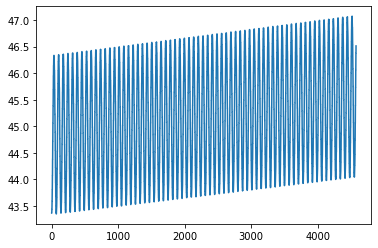

In [159]:
#slit position
def slit(t, s, omega):
    return -h-s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y
'''
def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))

'''
def trapezium_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    if v<0:
        print('moving the other direction')
    st = 'en'
    vel_vec = np.array([u, v])
    
    if u == 0:
        m = np.inf
    else:
        m = v/u
    slope = 1
    wall_y_left = h
    wall_y_right = slope*(2*l)+h
    while True:
        ball_y_right = m*(l-x)+y 
        ball_y_left = m*(-l-x)+y 
        if m == slope:
            x_int = 3
        else:
            x_int = (h-y+(slope*l)+(m*x))/(m-slope)
        print(x_int)
        if ((-l<x_int) and (x_int<l)) and st != "sl" :
            print('slop')
            xf = x_int
            yf = m*(xf-x)+y
            nor_vec = normalize(np.array([1, -(1/slope)]).reshape(2,1))
            st = "sl"
        elif h < ball_y_right < wall_y_right and st != "ve":
            #hit vertical
            print('vert')
            xf = l
            yf = ball_y_right
            nor_vec = normalize(np.array([-1, 0]).reshape(2,1))
            st = "ve"

        else:
            print('exit')
            yf = h
            xf = x + ((h-y)/vel_vec[1])* vel_vec[0]
            t += (h-y)/vel_vec[1]
            if vel_vec[1]>0:
                print('other way:', (h-y)/vel_vec[1])
            return (xf, yf, vel_vec[0], vel_vec[1], t)
                
        t += (xf-x)/vel_vec[0]
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        if np.linalg.norm(vel_vec) != np.linalg.norm(ref):
            print('unnormalized collision')
        x = xf
        y = yf
        vel_vec = np.array(ref)
        print(ref)
        m = float(ref[1]/ref[0])
        


#mapping function from one state to the next  
def trapezium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 
    #       't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>(h+s):
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            print('next wall: left')
        else:
            xf = l
            print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            print('next wall: trapezium enclosure')
            (xf, yf , uf, vf, tf) = trapezium_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            print('bottom bar')
            tf1 = tf - s/v
            tf2 = tf + s/v
            xf1 = x + u*time_step[di]
            if (coll(tf1, y, v, t, s, omega)*coll(tf2, y, v, t, s, omega))<0:
                root = rtsafe(i, tf+(np.pi/omega),y, v, t, s, omega, xacc=0.0000001, maxit = 100)
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v
                y_coll = slit(root ,s , omega)
                tf2 = root + ((-h-y_coll)/vf)
                xf2 = xf1 + u*(tf2-root)
                sign = np.sign(xf2)
                if abs(xf2)>l:
                    x_left = abs(xf2 - (sign*l))
                    quo = x_left//(2*l)
                    rem = x_left%(2*l)
                    if quo%2 == 1:
                        xf = sign*(rem-l)
                    elif quo%2 == 0:
                        xf = sign*(l-rem)
                yf = -h
                uf = u
                if abs(xf2)>l:
                    print('out!')
                
            else:
                print('root out of bounds')
            
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = trapezium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    #xs = []
    #ys = []
    es = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        es.append((v**2)+(u**2))
        #xs.append(x)
        #ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, es)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


    

In [183]:
x = 7
l = 2
sign = np.sign(x)
if abs(x)>l:
    x_left = abs(x - (sign*l))
    quo = x_left//(2*l)
    rem = x_left%(2*l)
    if quo%2 == 1:
        xf = sign*(rem-l)
    elif quo%2 == 0:
        xf = sign*(l-rem)
print(xf)

-1


In [16]:
k = [[(1,2,3),(1,2,3),(1,2,3)],[(1,2,3),(1,2,3),(1,2,3)],[(1,2,3),(1,2,3),(1,2,3)]]
np.save('k.npy', k)
b = np.load('k.npy')
print(b)

[[[1 2 3]
  [1 2 3]
  [1 2 3]]

 [[1 2 3]
  [1 2 3]
  [1 2 3]]

 [[1 2 3]
  [1 2 3]
  [1 2 3]]]


FileNotFoundError: [Errno 2] No such file or directory: 'k.npz'